### Imports

In [17]:
%load_ext autoreload

from dask.distributed import Client
from dask_image_processing import Image
import json
import os, time
import sys

from dask_image_processing import Image
from deconvolution import PSF

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['image.cmap'] = 'gray'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create a cluster on a separate notebook and create a client here

In [18]:
client = Client('tcp://127.0.0.1:44988')

### Load Image

In [19]:
file_path = '/hpc_utoz/vvib872/Data/MuSIC/CV54/J/roi_diff_bgm_deconv_CV54J_640.zarr'
img = Image.from_zarr(file_path)
img.info()

image_path: /hpc_utoz/vvib872/Data/MuSIC/CV54/J/roi_diff_bgm_deconv_CV54J_640.zarr


,Array,Chunk
Bytes,63.89 GB,67.11 MB
Shape,"(256, 7168, 8704)","(256, 256, 256)"
Count,953 Tasks,952 Chunks
Type,float32,numpy.ndarray


### View Image

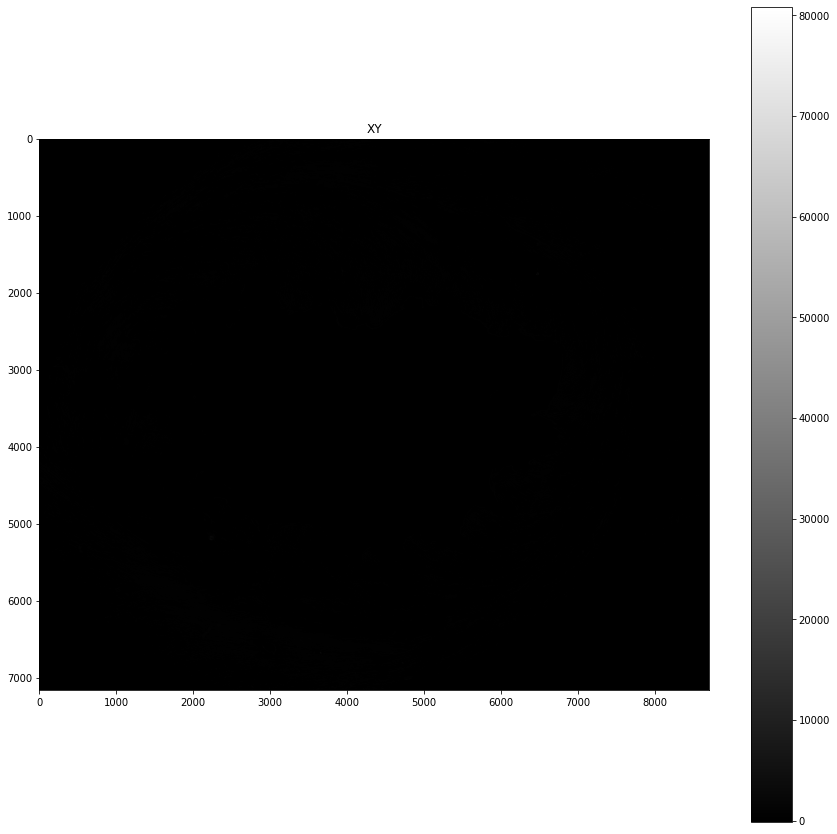

image_path: /hpc_utoz/vvib872/Data/MuSIC/CV54/J/roi_diff_bgm_deconv_CV54J_640.zarr


,Array,Chunk
Bytes,63.89 GB,67.11 MB
Shape,"(256, 7168, 8704)","(256, 256, 256)"
Count,953 Tasks,952 Chunks
Type,float32,numpy.ndarray


In [20]:
img.visualize(plane ='XY', slice_no=10, img_start=(0,0),img_end=(None,None))
img.info()

### Set parameters

In [21]:
import math

chunk_size = (256,256,256)
img_resolution = (1,1,1)

prefix = 'ds'
overlap = (16,16,16)

scale = (0.5,0.5,0.5) #double scale
save_chunk_size = tuple(map(lambda x,c: math.ceil(x*c),chunk_size,scale))
save_chunk_size = (64,64,64)
save_chunk_size

(64, 64, 64)

### Test on a sample

In [113]:
sample_range = ((600,856),(0,None),(0,None))

sample_img = img.sample(sample_range,prefix='roi')
sample_img.to_float()
sample_img.visualize(plane ='XY', slice_no=150, img_start=(0,0),img_end=(None,None))

sample_img.overlap(overlap)
sample_img.gaussian(sigma=0.7)
sample_img.resize(scale)
ds_img_resolution = tuple(map(lambda i, s: i / s, img_resolution, scale))
ds_overlap = tuple(map(lambda s, c: int(round(s * c)), overlap, scale))
sample_img.trim_overlap(ds_overlap)

dsample_img = Image.from_zarr(sample_img.to_zarr(prefix=prefix))

ValueError: parameter 'value': expected array with shape (128, 128, 128), got (128, 128, 64)

In [ ]:
dsample_img.visualize(plane ='XY', slice_no=50, img_start=(0,0),img_end=(None,None))
dsample_img.info()

### Filter

In [22]:
start_time = time.time()

# img.to_float()

img.overlap(overlap)
img.gaussian(sigma=0.7)
img.resize(scale)
ds_img_resolution = tuple(map(lambda i, s: i / s, img_resolution, scale))
ds_overlap = tuple(map(lambda s, c: int(round(s * c)), overlap, scale))
img.trim_overlap(ds_overlap)

img.overlap(overlap)
img.gaussian(sigma=0.7)
img.resize(scale)
ds_img_resolution = tuple(map(lambda i, s: i / s, img_resolution, scale))
ds_overlap = tuple(map(lambda s, c: int(round(s * c)), overlap, scale))
img.trim_overlap(ds_overlap)

# # chunk_s = (192,128,128)
# # sample_img.rechunk(chunk_s)
# img.frangi(sigma_range=range(2, 6), alpha=0.1, beta=0.7, c=0.1, gamma=1)
# img.anisotropic_diffusion(niter=15, kappa=20, gamma=0.1)
# img.trim_overlap(ds_overlap)

# img.dask_img = 255 * img.dask_img

filt_img_path = img.to_zarr(prefix=prefix, chunk_size=save_chunk_size, dtype='f4')
elapsed_time = time.time() - start_time
print("Elaspsed time:",elapsed_time)

parent_dir,name = os.path.split(img.file_path)
hostname = !hostname
filename,ext = os.path.splitext(filt_img_path)

metadata = {
    'uid': '54J',
    'img_in': {
        'name': name,
        'res': img_resolution,
    },

    'process' : {
         'name': prefix,
         'chunk_size': save_chunk_size,
         'overlap': overlap,
         'scale': scale,
     },

    'img_out' : {
        'name': os.path.basename(filt_img_path),
        'res': img_resolution,
        'elapsed_time':round(elapsed_time), 
        'hostname':hostname[0], 
        'workers': len(client.ncores()),
        'threads':next(iter(client.nthreads().values()))
    }
}

metadata_file = filename + '.json'
with open(metadata_file, 'w') as outfile:
            json.dump(metadata, outfile)

Elaspsed time: 99.78493928909302


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54790 remote=tcp://127.0.0.1:44988>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54808 remote=tcp://127.0.0.1:44988>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54832 remote=tcp://127.0.0.1:44988>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54836 remote=tcp://127.0.0.1:44988>


### Results

In [56]:
client.close() #also don't forget to shutdown the cluster